# KIE4033 Assignment 2
TWO ANALYSES:
1) Regression (Price Prediction)
2) Classification (Urgent Stock Prediction)

OUTPUT:
Printed metrics in output box
Plots shown inline
Excel file saved with all results


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, classification_report, roc_auc_score
)

# LOAD DATA

In [115]:
INPUT_XLSX  = r"C:\Users\nadynhida\OneDrive - Universiti Malaya\Desktop\YEAR 4\DATA\price_med.xlsx"
OUTPUT_XLSX = r"C:\Users\nadynhida\OneDrive - Universiti Malaya\Desktop\YEAR 4\DATA\KIE4033_Asgn2_results.xlsx"
print(df.shape)
np.random.seed(42)
# =============================
# 1) LOAD DATA
# =============================
df = pd.read_excel(INPUT_XLSX)

df.columns = (
    df.columns.astype(str)
    .str.replace("\u00a0", " ", regex=False)
    .str.strip()
)

print("Columns detected:")
print(df.columns.tolist())

# Column mapping (your dataset)
GEN_COL   = "Generic Name"
BRAND_COL = "Brand Name"
PACK_COL  = "Packaging Description (Per Pack)"
UNIT_COL  = "Unit (SKU)"
QTY_COL   = [c for c in df.columns if "Quantity" in c][0]
PRICE_COL = "Retail Price Per SKU Suggested by Product Registration Holder"
YEAR_COL  = "Price Updated Year"

(1361, 9)
Columns detected:
['Product Registration Number', 'Generic Name', 'Brand Name', 'Packaging Description (Per Pack)', 'Unit (SKU)', 'Quantity (SKU)', 'Retail Price Per SKU Suggested by Product Registration Holder', 'Retail Price per Pack Suggested by Product Registration Holder', 'Price Updated Year']


# CLEANING

In [116]:
for c in [GEN_COL, BRAND_COL, PACK_COL, UNIT_COL]:
    df[c] = df[c].fillna("unknown").astype(str)

for c in [QTY_COL, PRICE_COL, YEAR_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[PRICE_COL])
df[YEAR_COL] = df[YEAR_COL].fillna(df[YEAR_COL].median())
df[QTY_COL] = df[QTY_COL].fillna(df[QTY_COL].median())

df["log_price"] = np.log1p(df[PRICE_COL])

print("\nCleaned dataset shape:", df.shape)



Cleaned dataset shape: (1361, 10)


# EDA - PRICE DISTRIBUTION

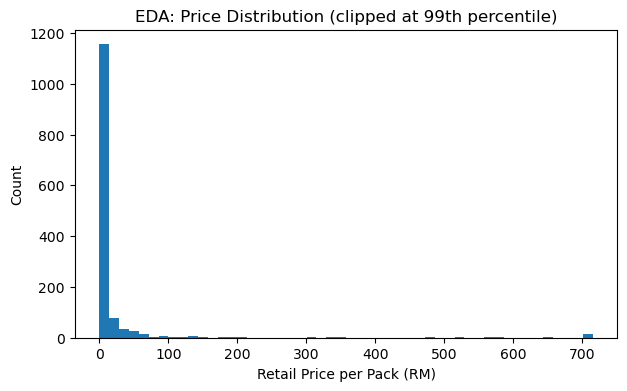

In [117]:
plt.figure(figsize=(7,4))
plt.hist(df[PRICE_COL].clip(upper=df[PRICE_COL].quantile(0.99)), bins=50)
plt.xlabel("Retail Price per Pack (RM)")
plt.ylabel("Count")
plt.title("EDA: Price Distribution (clipped at 99th percentile)")
plt.show()

# REGRESSION (RIDGE)


=== REGRESSION RESULTS (Ridge) ===
MAE_log: 0.5468
RMSE_log: 0.7745
R2: 0.6454
MAE_RM: 22.2698


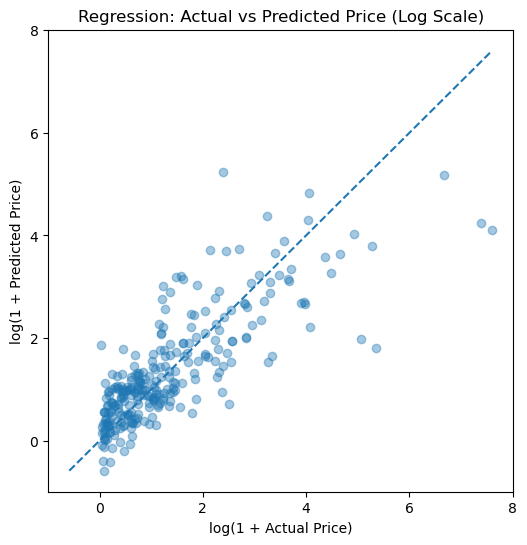

In [118]:
X_reg = df[[GEN_COL, BRAND_COL, PACK_COL, UNIT_COL, QTY_COL, YEAR_COL]].copy()
X_reg["text"] = (X_reg[GEN_COL] + " " + X_reg[BRAND_COL] + " " + X_reg[PACK_COL]).str.lower()
y_reg = df["log_price"]

preprocess_reg = ColumnTransformer(
    [
        ("text", TfidfVectorizer(min_df=2, max_features=15000), "text"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [UNIT_COL]),
        ("num", "passthrough", [QTY_COL, YEAR_COL]),
    ]
)

ridge = Pipeline(
    [
        ("prep", preprocess_reg),
        ("model", Ridge(alpha=1.0))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_reg[["text", UNIT_COL, QTY_COL, YEAR_COL]],
    y_reg, test_size=0.2, random_state=42
)

ridge.fit(X_train, y_train)
y_pred_log = ridge.predict(X_test)

# Metrics
y_test_rm = np.expm1(y_test)
y_pred_rm = np.expm1(y_pred_log)

reg_metrics = {
    "MAE_log": mean_absolute_error(y_test, y_pred_log),
    "RMSE_log": np.sqrt(mean_squared_error(y_test, y_pred_log)),
    "R2": r2_score(y_test, y_pred_log),
    "MAE_RM": mean_absolute_error(y_test_rm, y_pred_rm)
}

print("\n=== REGRESSION RESULTS (Ridge) ===")
for k, v in reg_metrics.items():
    print(f"{k}: {v:.4f}")

# --- Regression plot (LOG SCALE – NICE)
plt.figure(figsize=(6,6))
plt.scatter(np.log1p(y_test_rm), np.log1p(y_pred_rm), alpha=0.4)
mn = min(np.log1p(y_test_rm).min(), np.log1p(y_pred_rm).min())
mx = max(np.log1p(y_test_rm).max(), np.log1p(y_pred_rm).max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("log(1 + Actual Price)")
plt.ylabel("log(1 + Predicted Price)")
plt.title("Regression: Actual vs Predicted Price (Log Scale)")
plt.show()

# SIMULATE OPS DATA

In [119]:
ops = df.sample(3000, replace=True).copy()

ops["Transport_Mode"] = np.random.choice(["Boat", "4WD", "Mixed"], len(ops))
ops["LeadTime_Days"] = np.random.randint(3, 15, len(ops))
ops["Daily_Consumption"] = np.random.uniform(0.1, 5.0, len(ops)).round(3)
ops["Stock_OnHand"] = np.random.randint(1, 150, len(ops))

ops["Reorder_Point"] = np.ceil(
    ops["Daily_Consumption"] * ops["LeadTime_Days"]
).astype(int)

ops["Days_To_Stockout"] = (ops["Stock_OnHand"] / ops["Daily_Consumption"]).round(2)
ops["Stock_Value_RM"] = ops["Stock_OnHand"] * ops[PRICE_COL]

ops["Urgent"] = (
    (ops["Days_To_Stockout"] < ops["LeadTime_Days"]) |
    (ops["Stock_OnHand"] < ops["Reorder_Point"])
).astype(int)

# CLASSIFICATION


=== CLASSIFICATION RESULTS (Urgent Stock) ===
[[513   5]
 [  1  81]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       518
           1       0.94      0.99      0.96        82

    accuracy                           0.99       600
   macro avg       0.97      0.99      0.98       600
weighted avg       0.99      0.99      0.99       600

ROC-AUC: 0.9910066861286373


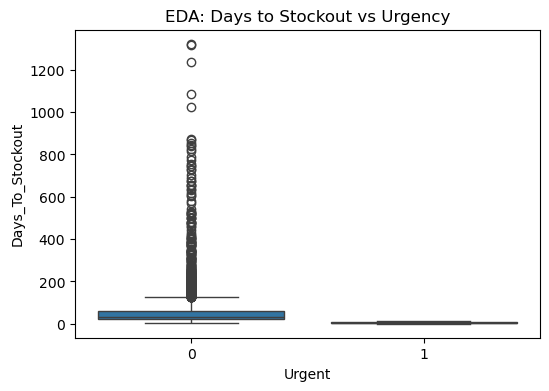

In [120]:
X = ops[[PACK_COL, UNIT_COL, "Transport_Mode",
         "LeadTime_Days", "Stock_OnHand",
         "Daily_Consumption", "Reorder_Point",
         "Days_To_Stockout", "Stock_Value_RM"]]

y = ops["Urgent"]

preprocess_clf = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         [PACK_COL, UNIT_COL, "Transport_Mode"]),
        ("num", "passthrough",
         ["LeadTime_Days", "Stock_OnHand",
          "Daily_Consumption", "Reorder_Point",
          "Days_To_Stockout", "Stock_Value_RM"])
    ]
)

clf = Pipeline([
    ("prep", preprocess_clf),
    ("model", DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    ))
])

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
y_prob = clf.predict_proba(X_te)[:,1]

print("\n=== CLASSIFICATION RESULTS (Urgent Stock) ===")
print(confusion_matrix(y_te, y_pred))
print(classification_report(y_te, y_pred))
print("ROC-AUC:", roc_auc_score(y_te, y_prob))

# --- Classification plot
plt.figure(figsize=(6,4))
sns.boxplot(x="Urgent", y="Days_To_Stockout", data=ops)
plt.title("EDA: Days to Stockout vs Urgency")
plt.show()




# SAVE TO EXCEL